In [10]:
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history, plot_intermediate_values
from sklearn.feature_selection import RFE


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn



from code.wrapper import utils

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import itertools
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

In [11]:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
# https://stackoverflow.com/a/23835410

excel_sheet = pd.read_excel("../Data/New/filtered_data.xlsx", sheet_name=["full_train", "full_test",
                                                                            "ionizable_train", "ionizable_test",
                                                                            "neutral_train", "neutral_test"])


full_train: pd.DataFrame = excel_sheet["full_train"]
full_test: pd.DataFrame = excel_sheet["full_test"]

neutral_train: pd.DataFrame = excel_sheet["neutral_train"]
neutral_test: pd.DataFrame = excel_sheet["neutral_test"]

ionizable_train: pd.DataFrame = excel_sheet["ionizable_train"]
ionizable_test: pd.DataFrame = excel_sheet["ionizable_test"]

Scaler = RobustScaler()
Norm = Normalizer()
# TRAIN
X_full_train = full_train.loc[:, full_train.columns != "Log_MP_RATIO"]
y_full_train = full_train["Log_MP_RATIO"]


X_neutral_train = neutral_train.loc[:, neutral_train.columns != "Log_MP_RATIO"]
y_neutral_train = neutral_train["Log_MP_RATIO"]

X_ionizable_train = ionizable_train.loc[:, ionizable_train.columns != "Log_MP_RATIO"]
y_ionizable_train = ionizable_train["Log_MP_RATIO"]
# Scaler.fit(X_full_train)
# X_full_train = pd.DataFrame(Scaler.transform(X_full_train), columns = X_full_train.columns)
#
# Norm.fit(X_full_train)
# X_full_train = pd.DataFrame(Norm.transform(X_full_train), columns=X_full_train.columns)

# TEST
X_full_test = full_test.loc[:, full_test.columns != "Log_MP_RATIO"]
y_full_test = full_test["Log_MP_RATIO"]

X_neutral_test = neutral_test.loc[:, neutral_test.columns != "Log_MP_RATIO"]
y_neutral_test = neutral_test["Log_MP_RATIO"]

X_ionizable_test = ionizable_test.loc[:, ionizable_test.columns != "Log_MP_RATIO"]
y_ionizable_test = ionizable_test["Log_MP_RATIO"]
#
# Scaler.fit(X_full_test)
# X_full_test = pd.DataFrame(Scaler.transform(X_full_test), columns = X_full_test.columns)
#
# Norm.fit(X_full_test)
# X_full_test = pd.DataFrame(Norm.transform(X_full_test), columns=X_full_test.columns)

# Full

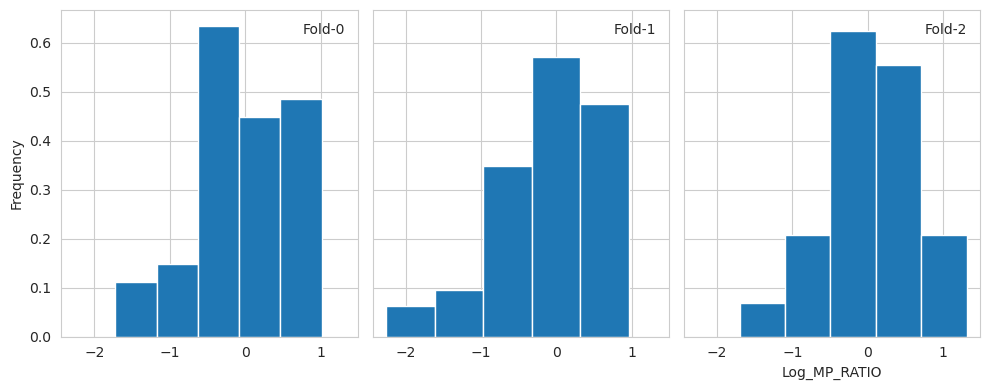

=====  RandomForestRegressor  ===== 
	R2			:	 0.9420535928030048 
	CV			:	 0.5466102981575817 
	Custom CV	:	 0.5755480308135995 
	Q2			:	 -0.059056465224875065


In [6]:
test_utils = utils.Utils(full_train)
test_utils.create_cv_folds(display=True)
test_utils.display_score(RandomForestRegressor(random_state=0), X_full_train, y_full_train, X_full_test, y_full_test)

In [5]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
    }

    clf = RandomForestRegressor(random_state=0, **params)

    estimator = utils.Utils(full_train)
    # return cross_val_score(clf, X_full_train, y_full_train, cv=5, n_jobs=-1).mean()
    return estimator.cross_value_score(clf)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, n_jobs=-1, show_progress_bar=True)
trial = study.best_trial
print(trial.value, trial.params)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.5883602812672956 {'n_estimators': 549, 'max_depth': 43, 'min_samples_split': 4, 'min_samples_leaf': 1}


=====  RandomForestRegressor  ===== 
	R2			:	 0.9333875458190323 
	CV			:	 0.5347677781440847 
	Custom CV	:	 0.5883088469111867 
	Q2			:	 -0.062268305190577466


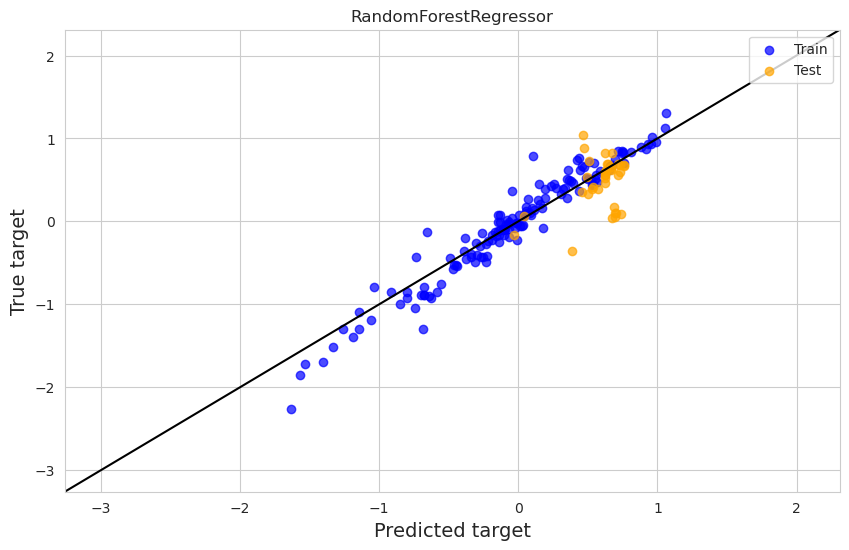

-0.062268305190577466


ValueError: y_true and y_pred have different number of output (357!=1)

In [7]:
from sklearn.metrics import r2_score

best_params = {'n_estimators': 524, 'max_depth': 41, 'min_samples_split': 4, 'min_samples_leaf': 1}
# best_params = {'n_estimators': 53, 'criterion': 'friedman_mse', 'max_depth': 127, 'min_samples_split': 21}
test_utils.display_score(RandomForestRegressor(**best_params, random_state=0), X_full_train, y_full_train, X_full_test, y_full_test)
# display(plot_optimization_history(study))

rr = RandomForestRegressor(**best_params, random_state=0).fit(X_full_train, y_full_train)
y_full_train_pred = rr.predict(X_full_train)
y_full_test_pred = rr.predict(X_full_test)

test_utils.display_graph(rr, X_full_train, X_full_test, y_full_train, y_full_test)

print(RandomForestRegressor(**best_params, random_state=0).fit(X_full_train, y_full_train).score(X_full_test, y_full_test))
r2_score(X_full_test, y_full_test_pred)

In [8]:
rr = RandomForestRegressor(**{'n_estimators': 524, 'max_depth': 41, 'min_samples_split': 4, 'min_samples_leaf': 1}, random_state=0)
rr.fit(X_full_train, y_full_train)


hyper_params = [{"n_features_to_select": list(range(1,len(X_full_train.columns)))}]

rfe = RFE(rr, step=1)

model_cv = GridSearchCV(estimator=rfe,
                        param_grid=hyper_params,
                        scoring="r2",
                        cv=3,
                        verbose=2,
                        return_train_score=True,
                        n_jobs=-1)


model_cv.fit(X_full_train, y_full_train)

cv_results = pd.DataFrame(model_cv.cv_results_)

best_rfe = model_cv.best_estimator_


plt.figure(figsize=(16,6))
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel("number of features")
plt.ylabel("R2")
plt.title("Optimal number of features")
plt.legend(["test score", "train score"], loc="upper left")
plt.show()


test_utils.display_score(best_rfe,
                         X_full_train, y_full_train,
                         X_full_test, y_full_test)

Fitting 3 folds for each of 356 candidates, totalling 1068 fits



KeyboardInterrupt



# Ionizable

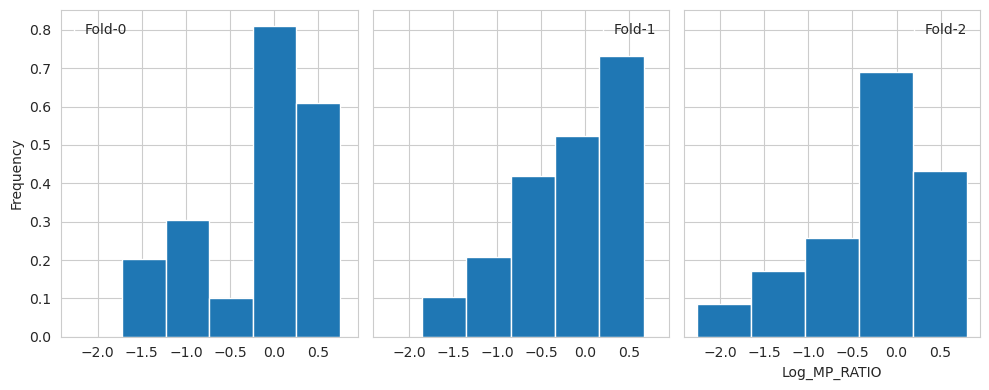

=====  RandomForestRegressor  ===== 
	R2			:	 0.9160899741751123 
	CV			:	 0.12088751807064242 
	Custom CV	:	 0.29894290186287575 
	Q2			:	 0.057360941458256764


In [13]:
test_utils = utils.Utils(ionizable_train)
test_utils.create_cv_folds(display=True)
test_utils.display_score(RandomForestRegressor(random_state=0), X_ionizable_train, y_ionizable_train, X_ionizable_test, y_ionizable_test)

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 10000),
        "criterion": trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse"]),
        'max_depth': trial.suggest_int('max_depth', 4, 400),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 1000),
        # 'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 1000),
        # "min_weight_fraction_leaf": trial.suggest_float("min_weight_fraction_leaf", 1e-10, 0.5),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2", None]),
        # "min_impurity_decrease": trial.suggest_float("min_impurity_decrease", 1e-10, 100),
        # "ccp_alpha": trial.suggest_float("ccp_alpha", 1e-10, 100)
    }

    clf = RandomForestRegressor(random_state=0, **params)

    estimator = utils.Utils(ionizable_train)
    # return cross_val_score(clf, X_ionizable_train, y_ionizable_train, cv=5, n_jobs=-1).mean()
    return estimator.cross_value_score(clf)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300, n_jobs=-1, show_progress_bar=True)
trial = study.best_trial
print(trial.value, trial.params)

  0%|          | 0/300 [00:00<?, ?it/s]

/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this

=====  RandomForestRegressor  ===== 
	R2			:	 0.7595980804813367 
	CV			:	 0.22545198757875393 
	Custom CV	:	 0.387540298408736 
	Q2			:	 0.07286268498874604


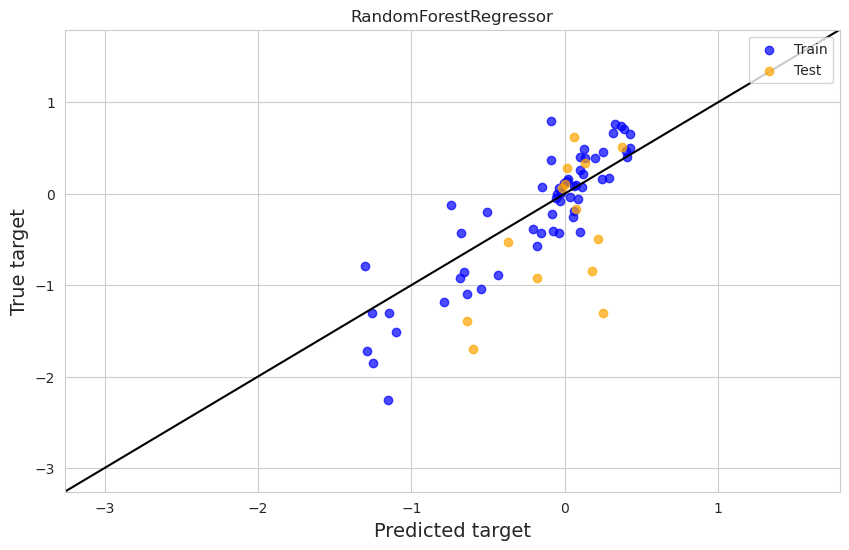

In [12]:
# best_params = {'n_estimators': 53, 'criterion': 'friedman_mse', 'max_depth': 127, 'min_samples_split': 21}
best_params = {'n_estimators': 58, 'criterion': 'friedman_mse', 'max_depth': 180, 'min_samples_split': 20, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.05652036394251227, 'max_features': 0.300188179100633, 'min_impurity_decrease': 1.1472025475281744, 'ccp_alpha': 0.00029372853348070275}

test_utils.display_score(RandomForestRegressor(**best_params, random_state=0), X_ionizable_train, y_ionizable_train, X_ionizable_test, y_ionizable_test)
# display(plot_optimization_history(study))

rr = RandomForestRegressor(**best_params, random_state=0).fit(X_ionizable_train, y_ionizable_train)

test_utils.display_graph(rr, X_ionizable_train, X_ionizable_test, y_ionizable_train, y_ionizable_test)

In [67]:
from sklearn.metrics import r2_score

X_pred = X_ionizable_test
y_obs = y_ionizable_test

y_test_pred = rr.predict(X_pred)
y_test_pred_df = pd.DataFrame(y_test_pred, columns=["y_pred"])

df.to_csv("./Q2_neutral_random_forest.csv", sep=",")

r2_score(y_obs, y_test_pred_df)


0.07286268498874604

In [32]:
from statistics import mean

x = ()


def tss(a):
    m = mean(a)
    n = 0
    for i in a:
        n += ((i-m)**2)
    return (n)

tss(y_full_train)
# print("SS_tot FULL: ",tss(y_full_test.tolist()))
# print("SS_tot IONIZABLE: ",tss(y_ionizable_test.tolist()))
# print("SS_tot NEUTRAL: ",tss(y_neutral_test.tolist()))

65.21083495210101

In [34]:
from sklearn.linear_model import LinearRegression


# reading csv file as pandas dataframe

# independent variable
X = X_ionizable_test

# output variable (dependent)
y = y_ionizable_test

# using the linear regression model
model = LinearRegression()

# fitting the data
model.fit(X, y)

# predicting values
y_pred = model.predict(X)
df = pd.DataFrame({'Actual': y, 'Predicted':
    y_pred})

print(' residual sum of squares is : ', 1 - (np.sum(np.square(df['Predicted'] - df['Actual'])) / 65.21083495210101))

 residual sum of squares is :  1.0


# Neutral

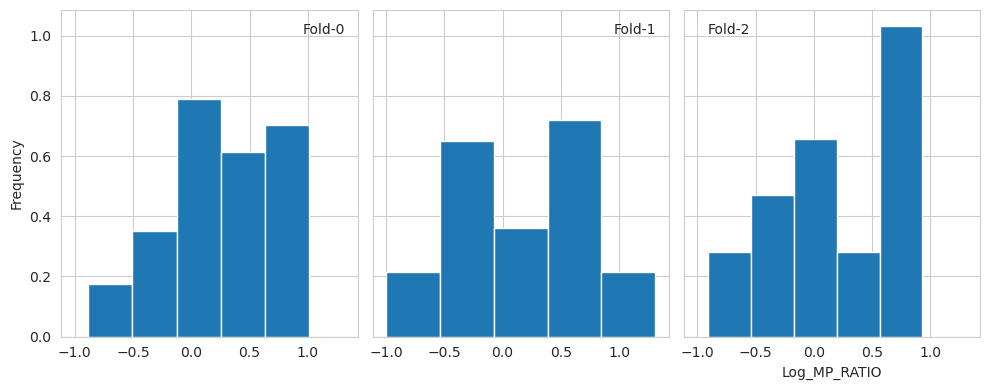

=====  RandomForestRegressor  ===== 
	R2			:	 0.9564490815363942 
	CV			:	 0.535187258969056 
	Custom CV	:	 0.6406820990181907 
	Q2			:	 0.047052120141054865


In [4]:
test_utils = utils.Utils(neutral_train)
test_utils.create_cv_folds(display=True)
test_utils.display_score(RandomForestRegressor(random_state=0), X_neutral_train, y_neutral_train, X_neutral_test, y_neutral_test)

In [30]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        "criterion": trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse"]),
        'max_depth': trial.suggest_int('max_depth', 4, 400),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 1000),
        # 'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 1000),
        # "min_weight_fraction_leaf": trial.suggest_float("min_weight_fraction_leaf", 1e-10, 0.5),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2", None]),
    }

    clf = RandomForestRegressor(random_state=0, **params)

    estimator = utils.Utils(neutral_train)
    # return cross_val_score(clf, X_neutral_train, y_neutral_train, cv=5, n_jobs=-1).mean()
    return estimator.cross_value_score(clf)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, n_jobs=-1, show_progress_bar=True)
trial = study.best_trial
print(trial.value, trial.params)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this

0.6716015379367475 {'n_estimators': 95, 'criterion': 'squared_error', 'max_depth': 276, 'min_samples_split': 3, 'max_features': 'sqrt'}


=====  RandomForestRegressor  ===== 
	R2			:	 0.9507681811971471 
	CV			:	 0.5670290349853246 
	Custom CV	:	 0.6716015379367475 
	Q2			:	 0.004264775427471501
0.004264775427471501


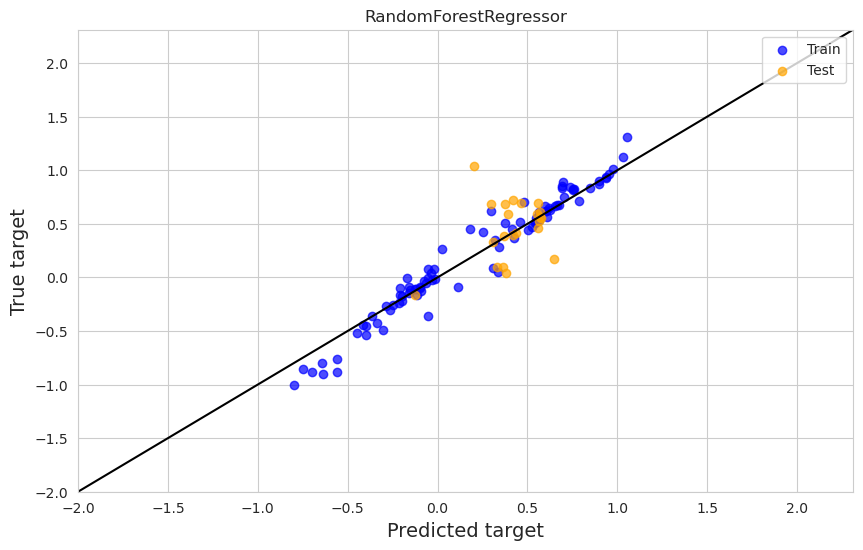

In [43]:
best_params = {'n_estimators': 95, 'criterion': 'squared_error', 'max_depth': 276, 'min_samples_split': 3, 'max_features': 'sqrt'}
test_utils.display_score(RandomForestRegressor(**best_params, random_state=0), X_neutral_train, y_neutral_train, X_neutral_test, y_neutral_test)
# display(plot_optimization_history(study))

rr = RandomForestRegressor(**best_params, random_state=0).fit(X_neutral_train, y_neutral_train)

rr.score()

# test_utils.display_graph(rr, X_neutral_train, X_neutral_test, y_neutral_train, y_neutral_test   )

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- ASA_H
- ASA_P
- BCUT_SMR_0
- CASA+
- FASA_P
- ...
Feature names seen at fit time, yet now missing:
- E_nb
- GCUT_SLOGP_0
- MACCS(--8)
- MACCS(-11)
- MACCS(-16)
- ...


In [57]:
y_neutral_test.shape

(22,)

[Text(0, 0, 'ASA+'),
 Text(1, 0, 'DASA'),
 Text(2, 0, 'CASA+'),
 Text(3, 0, 'DCASA'),
 Text(4, 0, 'E_ele'),
 Text(5, 0, 'E_sol'),
 Text(6, 0, 'PEOE_VSA+0'),
 Text(7, 0, 'PEOE_VSA+1'),
 Text(8, 0, 'pmi3'),
 Text(9, 0, 'SMR_VSA0'),
 Text(10, 0, 'SMR_VSA2'),
 Text(11, 0, 'vsurf_D1'),
 Text(12, 0, 'vsurf_D3'),
 Text(13, 0, 'vsurf_W2'),
 Text(14, 0, 'vsurf_Wp3'),
 Text(15, 0, 'weinerPath')]

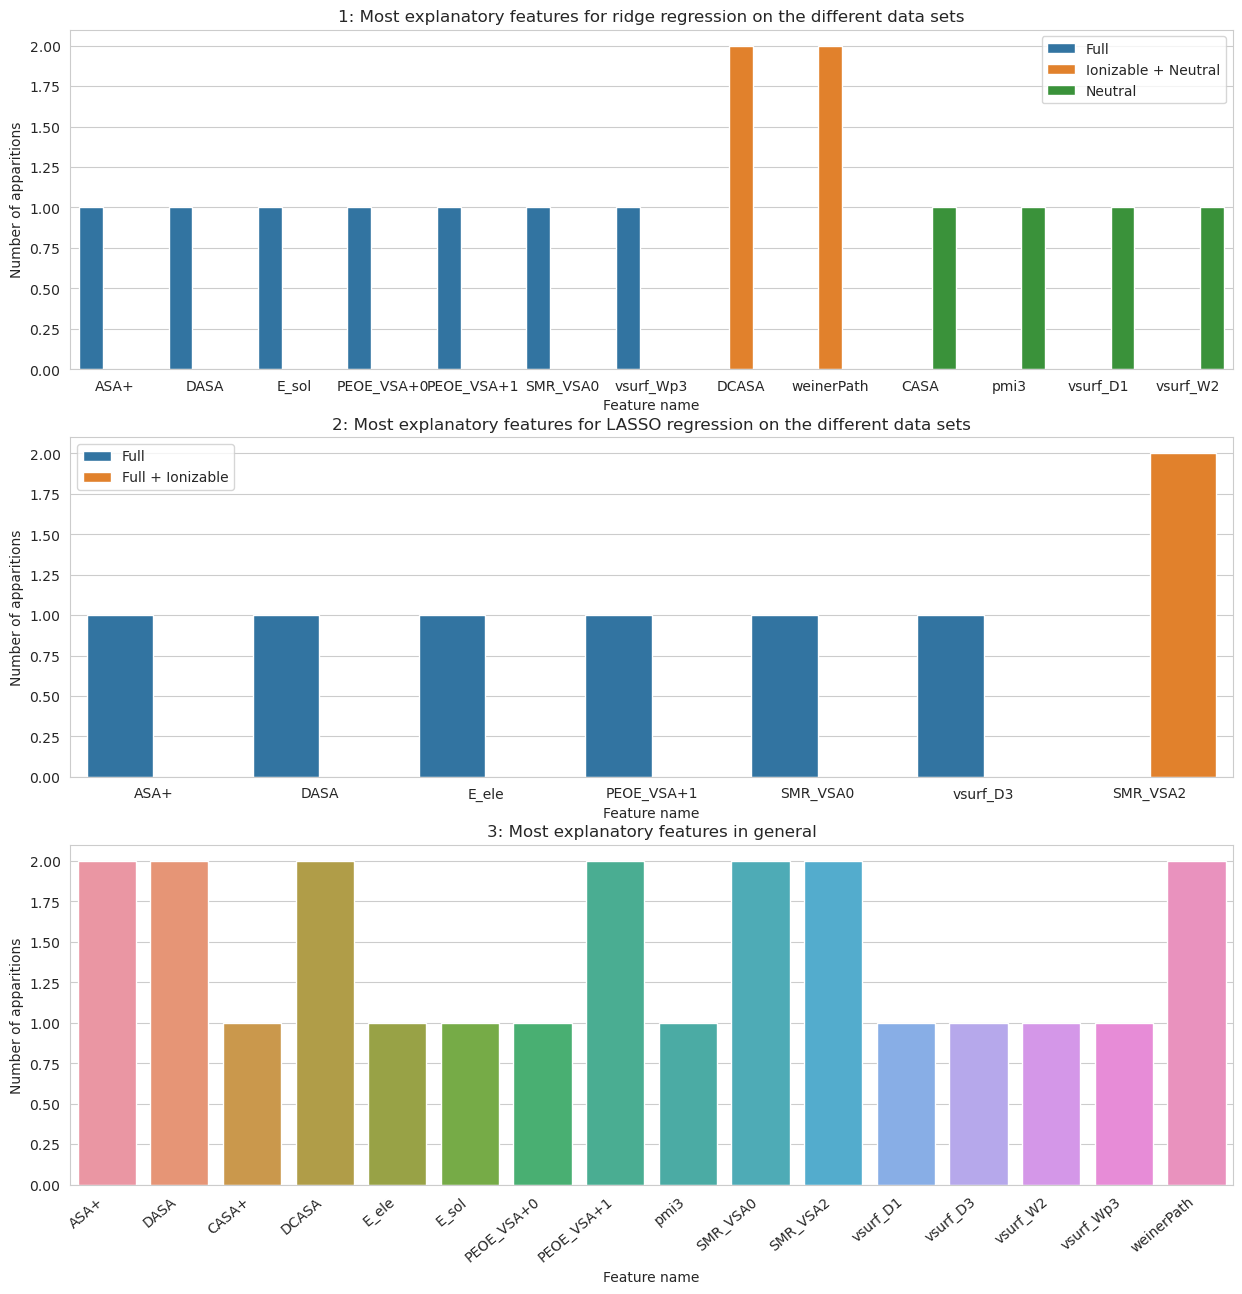

In [18]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
d = {"Feature names": ["ASA+", "DASA", "CASA+", "DCASA", "E_ele", "E_sol", "PEOE_VSA+0", "PEOE_VSA+1", "pmi3", "SMR_VSA0", "SMR_VSA2",
                       "vsurf_D1", "vsurf_D3", "vsurf_W2", "vsurf_Wp3", "weinerPath"],
     "Number of apparitions": [2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2]
     }

rrd = {"Feature names": ["ASA+", "DASA", "E_sol", "PEOE_VSA+0", "PEOE_VSA+1", "SMR_VSA0", "vsurf_Wp3",
                         "DCASA", "weinerPath",
                         "CASA", "pmi3", "vsurf_D1", "vsurf_W2"],
       "Number of apparitions": [1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1],
       "Data set": ["Full", "Full", "Full", "Full", "Full", "Full", "Full", "Ionizable + Neutral", "Ionizable + Neutral", "Neutral", "Neutral", "Neutral", "Neutral"]}


rrl = {"Feature names": ["ASA+", "DASA", "E_ele", "PEOE_VSA+1", "SMR_VSA0", "vsurf_D3", "SMR_VSA2"],
       "Number of apparitions": [1, 1, 1, 1, 1, 1, 2],
       "Data set": ["Full", "Full", "Full", "Full", "Full", "Full", "Full + Ionizable"]}


df = pd.DataFrame(data=d)

fig, axs = plt.subplots(nrows=3, figsize=(15, 15))
sns.barplot(x="Feature names", y="Number of apparitions", data=rrd, hue="Data set", ax=axs[0])
sns.barplot(x="Feature names", y="Number of apparitions", data=rrl, hue="Data set", ax=axs[1])
sns.barplot(x="Feature names", y="Number of apparitions", data=df, ax=axs[2])

axs[0].set_title("1: Most explanatory features for ridge regression on the different data sets")
axs[0].set_xlabel("Feature name")
axs[0].set_ylabel("Number of apparitions")


axs[1].set_title("2: Most explanatory features for LASSO regression on the different data sets")
axs[1].set_xlabel("Feature name")
axs[1].set_ylabel("Number of apparitions")

axs[2].set_title("3: Most explanatory features in general")
axs[2].set_xlabel("Feature name")
axs[2].set_ylabel("Number of apparitions")

axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=40, ha="right")